**Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import math
from keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error 

**Function to plot LSTM loss with respect to epochs**

In [2]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Mean Square Error')
    plt.title(title)
    plt.legend()

    plt.show()

**Function to genrate Y Data (t+5 seconds)**

In [3]:
def predict_future(data,predict = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,predict+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)

    df = df.values
    supervised_data = df[:,:predict]
    supervised_data = np.column_stack( [supervised_data, df[:,predict]])
    return supervised_data

**Function to convert normal data to 30 seconds input**

In [4]:
def to_supervised(data,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

**Mount Drive Path**

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
file="/content/drive/MyDrive/group1[0].csv"
data_set = pd.read_csv(file, index_col="Time (sec)")
data_set=data_set.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
data_set.tail()

Mounted at /content/drive


,Load of Online Machines(%),Lowest Load(%),Highest Load(%),# of Requests,Powered BED Count,Group Power(w),Active BED Count,S3 Powered Count,Online BED Count,Group Power Factor (%),Average CPU Core Temp. (°c),Hottest CPU Core Temp. (°c),WC Average CPU Core Temp (°c),WC Hottest CPU Core Temp (°c),Capacity Used(%),I/O Load of Online Machines(%),I/O Capacity Used(%),# Batch Jobs
Time (sec),,,,,,,,,,,,,,,,,,
8399.9,0.17,0.14,0.18,0,20,2495,16,0,20,0.491406,41,57,0,2810179280,0.0,0.0,0.0,0
8400.9,0.18,0.15,0.20,0,20,2514,16,0,20,0.487187,41,57,0,2810179280,0.0,0.0,0.0,0
8401.9,0.24,0.17,0.96,0,20,2515,16,0,20,0.486875,41,57,0,2810179280,0.0,0.0,0.0,0
8402.9,0.18,0.16,0.20,0,20,2506,16,0,20,0.491719,42,57,0,2810179280,0.0,0.0,0.0,0
8403.9,0.20,0.16,0.49,0,20,2505,16,0,20,0.491875,41,56,0,2810179280,0.0,0.0,0.0,0


**Plot all values wrt Time**

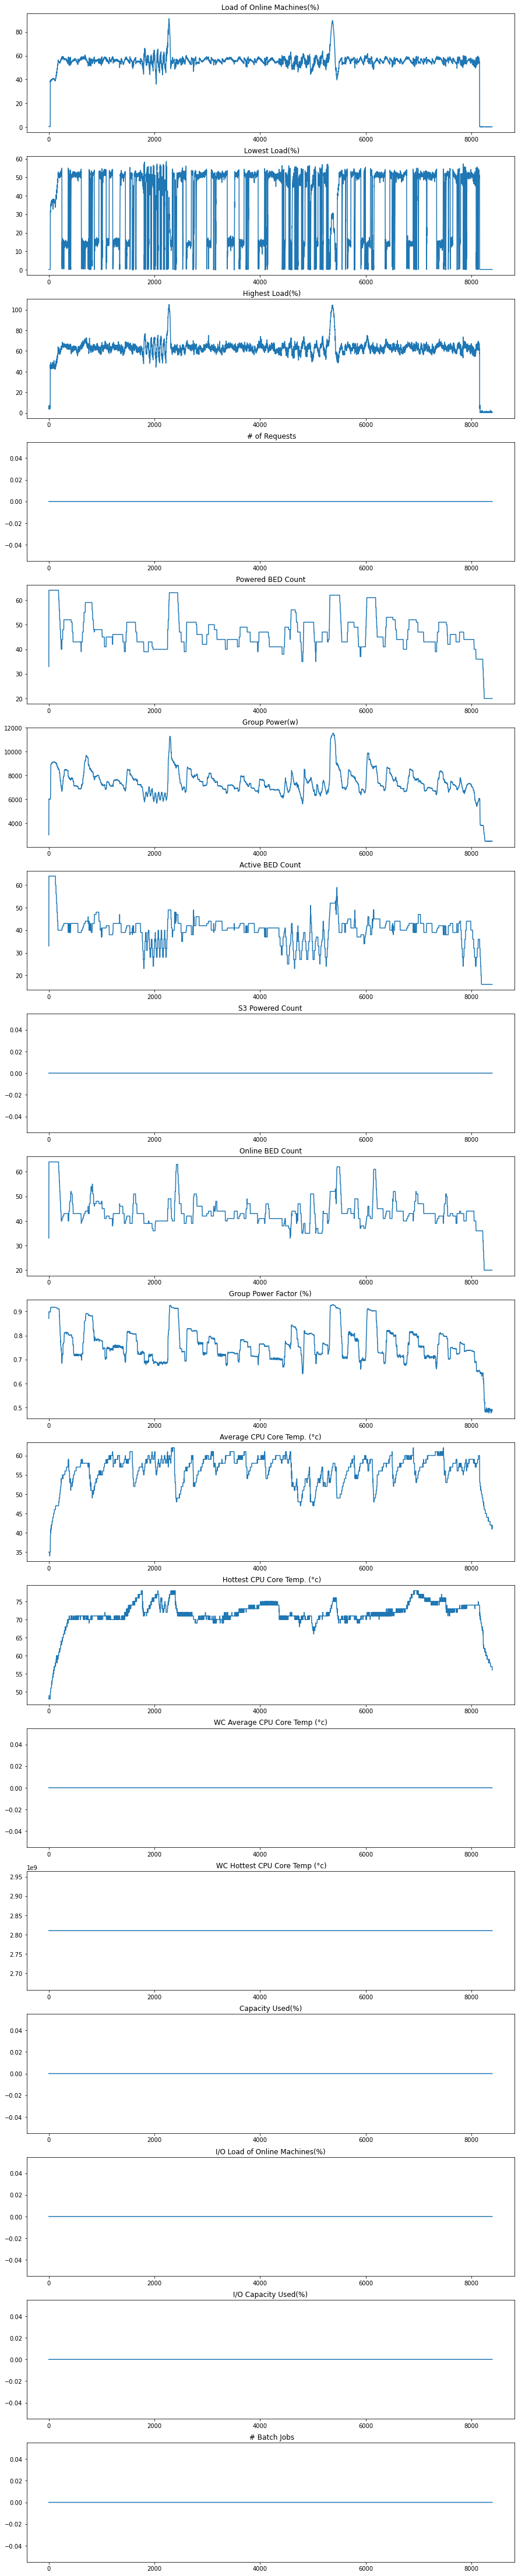

In [6]:
values = data_set.values
x=1
f=plt.figure()
f.set_figwidth(15)
f.set_figheight(85)
for i in range (0,18):
    plt.subplot(19, 1, x)
    plt.plot(values[:, i])
    plt.title(data_set.columns[i])
    x += 1
plt.show()

**Remove Columns which doesnot add value**

In [7]:
all_columns=list(data_set.columns)
print("All coumns list",all_columns)
not_selected_columns=['WC Average CPU Core Temp (°c)',' # of Requests','S3 Powered Count',' # Batch Jobs','I/O Capacity Used(%)','I/O Load of Online Machines(%)','Capacity Used(%)','WC Hottest CPU Core Temp (°c)']
selected_columns= all_columns
for column in not_selected_columns:
    if column in selected_columns:
        selected_columns.remove(column)
print("Selected Columns List",selected_columns)

All coumns list ['Load of Online Machines(%)', ' Lowest Load(%)', ' Highest Load(%)', ' # of Requests', 'Powered BED Count', 'Group Power(w)', 'Active BED Count', 'S3 Powered Count', 'Online BED Count', 'Group Power Factor (%)', 'Average CPU Core Temp. (°c)', ' Hottest CPU Core Temp. (°c)', 'WC Average CPU Core Temp (°c)', ' WC Hottest CPU Core Temp (°c)', 'Capacity Used(%)', 'I/O Load of Online Machines(%)', 'I/O Capacity Used(%)', ' # Batch Jobs']
Selected Columns List ['Load of Online Machines(%)', ' Lowest Load(%)', ' Highest Load(%)', 'Powered BED Count', 'Group Power(w)', 'Active BED Count', 'Online BED Count', 'Group Power Factor (%)', 'Average CPU Core Temp. (°c)', ' Hottest CPU Core Temp. (°c)', ' WC Hottest CPU Core Temp (°c)']


**Scaling Features Selected**

In [8]:
data_set=data_set[selected_columns]
selected_columns=  [' Highest Load(%)',' Lowest Load(%)', 'Powered BED Count', 'Group Power(w)', 'Active BED Count', 'Online BED Count', 'Group Power Factor (%)', 'Average CPU Core Temp. (°c)', ' Hottest CPU Core Temp. (°c)', ' WC Hottest CPU Core Temp (°c)']
values = data_set[selected_columns]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
feature_data = pd.DataFrame(scaler.fit_transform(values), columns=selected_columns)
feature_data.insert(0, 'Load of Online Machines(%)', list(data_set['Load of Online Machines(%)']/100), True)



**Convert  Normal data to Supervised Data**



In [9]:
lookback = 30
supervised = to_supervised(feature_data,lag=lookback)
supervised=supervised[~np.isnan(supervised).any(axis=1)]
pd.DataFrame(supervised[:,0]).head()
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330
0,0.0030,0.035166,0.002562,0.295455,0.059998,0.354167,0.295455,0.874400,0.035714,0.0,0.0,0.0027,0.035452,0.002392,0.977273,0.384140,0.979167,0.977273,0.932510,0.035714,0.0,0.0,0.0026,0.036215,0.002733,1.0,0.392412,1.0,1.0,0.935366,0.035714,0.000000,0.0,0.0029,0.036596,0.002904,1.0,0.392743,1.0,1.0,...,1.0,1.0,0.934673,0.035714,0.000000,0.0,0.0031,0.066711,0.002562,1.0,0.390427,1.0,1.0,0.934327,0.035714,0.000000,0.0,0.3731,0.443629,0.465665,1.0,0.390427,1.0,1.0,0.934327,0.071429,0.000000,0.0,0.3888,0.411131,0.515545,1.0,0.391199,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3765
1,0.0027,0.035452,0.002392,0.977273,0.384140,0.979167,0.977273,0.932510,0.035714,0.0,0.0,0.0026,0.036215,0.002733,1.000000,0.392412,1.000000,1.000000,0.935366,0.035714,0.0,0.0,0.0029,0.036596,0.002904,1.0,0.392743,1.0,1.0,0.933982,0.035714,0.000000,0.0,0.0029,0.035357,0.002562,1.0,0.392743,1.0,1.0,...,1.0,1.0,0.934327,0.035714,0.000000,0.0,0.3731,0.443629,0.465665,1.0,0.390427,1.0,1.0,0.934327,0.071429,0.000000,0.0,0.3888,0.411131,0.515545,1.0,0.391199,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3765,0.417898,0.526136,1.0,0.391199,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3914
2,0.0026,0.036215,0.002733,1.000000,0.392412,1.000000,1.000000,0.935366,0.035714,0.0,0.0,0.0029,0.036596,0.002904,1.000000,0.392743,1.000000,1.000000,0.933982,0.035714,0.0,0.0,0.0029,0.035357,0.002562,1.0,0.392743,1.0,1.0,0.933982,0.035714,0.000000,0.0,0.0035,0.063185,0.002733,1.0,0.392963,1.0,1.0,...,1.0,1.0,0.934327,0.071429,0.000000,0.0,0.3888,0.411131,0.515545,1.0,0.391199,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3765,0.417898,0.526136,1.0,0.391199,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3914,0.436005,0.547318,1.0,0.391971,1.0,1.0,0.955775,0.178571,0.066667,0.0,0.3927
3,0.0029,0.036596,0.002904,1.000000,0.392743,1.000000,1.000000,0.933982,0.035714,0.0,0.0,0.0029,0.035357,0.002562,1.000000,0.392743,1.000000,1.000000,0.933982,0.035714,0.0,0.0,0.0035,0.063185,0.002733,1.0,0.392963,1.0,1.0,0.933637,0.035714,0.000000,0.0,0.0033,0.067474,0.002562,1.0,0.391750,1.0,1.0,...,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3765,0.417898,0.526136,1.0,0.391199,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3914,0.436005,0.547318,1.0,0.391971,1.0,1.0,0.955775,0.178571,0.066667,0.0,0.3927,0.428286,0.531773,1.0,0.415242,1.0,1.0,0.962001,0.214286,0.066667,0.0,0.3869
4,0.0029,0.035357,0.002562,1.000000,0.392743,1.000000,1.000000,0.933982,0.035714,0.0,0.0,0.0035,0.063185,0.002733,1.000000,0.392963,1.000000,1.000000,0.933637,0.035714,0.0,0.0,0.0033,0.067474,0.002562,1.0,0.391750,1.0,1.0,0.934673,0.035714,0.033333,0.0,0.0031,0.066616,0.002392,1.0,0.391419,1.0,1.0,...,1.0,1.0,0.938133,0.178571,0.033333,0.0,0.3914,0.436005,0.547318,1.0,0.391971,1.0,1.0,0.955775,0.178571,0.066667,0.0,0.3927,0.428286,0.531773,1.0,0.415242,1.0,1.0,0.962001,0.214286,0.066667,0.0,0.3869,0.429429,0.576016,1.0,0.415242,1.0,1.0,0.962001,0.214286,0.066667,0.0,0.3879


In [10]:
features = feature_data.shape[1]
train_length =math.ceil( 0.7*len(feature_data))
X = supervised[:,:features*lookback]
y = supervised[:,319]
X_train = X[:train_length,:]
X_test = X[train_length:,:]
X_test=X_test[:-5, :]
x_train = X_train.reshape(X_train.shape[0], lookback, features)
x_test = X_test.reshape(X_test.shape[0], lookback, features)
print (x_train.shape,x_test.shape)

(5875, 30, 11) (2482, 30, 11)


In [11]:
YCAP=predict_future(y,4)
Y_train = YCAP[1:train_length+1]
Y_test  = YCAP[train_length+1:]
Y_test  = Y_test[:-4, :]
print (Y_train.shape,Y_test.shape)
y_train = Y_train.reshape(Y_train.shape[0], 5, 1)
y_test = Y_test.reshape(Y_test.shape[0], 5, 1)
print (y_train.shape,y_test.shape)

(5875, 5) (2482, 5)
(5875, 5, 1) (2482, 5, 1)


**Random Forest Model with Estimators 100**

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
rf.fit(X_train, Y_train);
rf_predictions = rf.predict(X_test)
mse = mean_squared_error(Y_test, rf_predictions)
print(mse)

0.01577563650647273


**Single Layer LSTM Model**

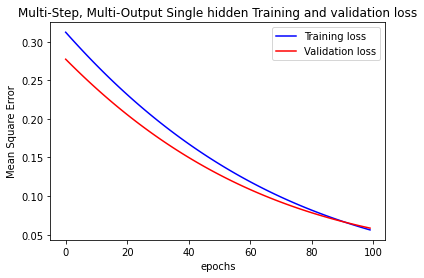

In [13]:
model = Sequential()
model.add( LSTM( 200, input_shape = ( lookback,x_train.shape[2]) ) )
model.add(Dense(1, activation='relu'))
model.add( Dense(1) )
model.compile( loss = "mse", optimizer = "adam")
singlelayer_history=model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 100 , batch_size = 1500, verbose = 0, shuffle = False)
plot_train_history(singlelayer_history, 'Multi-Step, Multi-Output Single hidden Training and validation loss')

**Multi Layer LSTM**

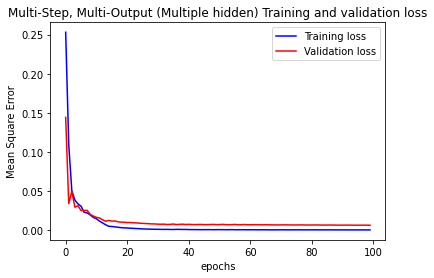

In [14]:
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector
from tensorflow.python.keras.layers import TimeDistributed,Flatten, Bidirectional
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(lookback, x_train.shape[2])))
model.add(RepeatVector(y_train.shape[1]))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
multilayer_history=model.fit(x_train, y_train,validation_data = (x_test,y_test),epochs = 100 , batch_size = 1500, verbose = 0, shuffle = False)
plot_train_history(multilayer_history, 'Multi-Step, Multi-Output (Multiple hidden) Training and validation loss')
